In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix

In [2]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

C:\Users\anai\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\Users\anai\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\anai\AppData\Roaming\Python\Python36\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\anai\AppData\Roaming\Python\P

In [3]:
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)

In [4]:
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.optimizer = optimizer
        self.W = initializer.W(self.n_nodes1, self.n_nodes2)
        self.B = initializer.B(self.n_nodes2)
        
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes_bf)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes_af)
            出力
        """
        A = np.dot(X, self.W) +  self.B
        return A

    def backward(self, dA, Z_m1):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        dB = np.sum(dA, axis=0)
        dW = np.dot(Z_m1.T, dA)
        dZ = np.dot(dA, self.W.T)     

        # 更新
        #self = self.optimizer.update(dW, dB, self.W, self.W)
        self.W = self.optimizer.update(dW, self.W)
        self.B = self.optimizer.update(dB, self.B)

        return dZ


In [5]:
class SimpleInitializer:
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self, sigma):
        self.sigma = sigma
        #display(self.sigma.Calc)
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        W :
        """
        W = self.sigma * np.random.randn(n_nodes1, n_nodes2)
        return W
    
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数

        Returns
        ----------
        B :
        """
        B = self.sigma * np.random.randn(1, n_nodes2)
        return B

In [6]:
class SGD:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr

    def update(self, dWorB, WorB):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス

        Returns
        ----------
        layer : 更新後の層のインスタンス
        """
        self.WorB = WorB
        self.WorB -= self.lr*dWorB
        return self.WorB

In [17]:
class Activation:
    """
    活性化関数　tanh
    Parameters
    ----------
    """
    def __init__(self):
        pass
    def tanh_fw(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes_bf)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes_af)
            出力
        """     
        Z = np.tanh(X)
        return Z

    def tanh_bw(self, dZ, A):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        dA = dZ * (1 - np.tanh(A)**2)  
        return dA
    
    def softmax_fw(self, X, y):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes_bf)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes_af)
            出力
        """     
        Z = np.exp(X) / np.sum(np.exp(X), axis=1).reshape(-1,1)
        return Z

    def softmax_bw(self, Z, y):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        dA = Z - y
        return dA

    def entropy(self, Z, y):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes_bf)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes_af)
            出力
        """     
        L = -1*np.average(np.sum(y * np.log(Z), axis=1), axis=0)
        return L

In [18]:
class Relu:
    """
    活性化関数　tanh
    Parameters
    ----------
    """
    def __init__(self):
        pass
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes_bf)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes_af)
            出力
        """     
        if X>0:
            Z = X
        else:
            Z =0            
        return Z

    def backward(self, dZ):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """
        if dZ>0:
            dA = 1
        else:
            dA =0            
        return dA


In [19]:
class Xavier:
    """
    活性化関数　tanh
    Parameters
    ----------
    """
    def __init__(self,n):
        self.n=n
        self.calc = 1/np.sqrt(self.n)

In [20]:
class He:
    """
    活性化関数　tanh
    Parameters
    ----------
    """
    def __init__(self,n):
        self.n=n
    def _Calc(self):
        """
        フォワード
        Parameters
        ----------
        n : 次の形のndarray, shape (batch_size, n_nodes_bf)
            入力
        Returns
        ----------
        siguma : 次の形のndarray, shape (batch_size, n_nodes_af)
            出力
        """     
        siguma = np.sqrt(2/self.n)            
        return siguma

In [21]:
class AdaGrad:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr):
        self.lr = lr
    def update(self, layer, d_):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス

        Returns
        ----------
        layer : 更新後の層のインスタンス
        """
        self.H += d_**2
        layer -= self.lr*d_/np.sqrt(self.H)
        return layer

In [22]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練用データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [23]:
class ScratchSimpleNeuralNetrowkClassifier():
    """
    シンプルな三層ニューラルネットワーク分類器

    Parameters
    ----------
    bp : int
        バックプロパゲーション回数
    Attributes
    ----------
    """
    def __init__(self, how_prp="htan", n_nodes1=400, n_nodes2=200, n_output=10, n_epoq=5, batch_size=20, 
                 lr=0.001, verbose = True):
        self.verbose = verbose
        self.n_epoq = n_epoq
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.n_output = n_output
        self.batch_size = batch_size
        self.how_prp = how_prp
        self.lr = lr
        self.loss_list = np.array([])
        self.loss_val_list = np.array([])

    def fit(self, X, y):
        """
        ニューラルネットワーク分類器を学習する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練用データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練用データの正解値
        """
        self.n_features = X.shape[1]
        optimizer = SGD(self.lr)
        sigma1=Xavier(self.n_features)
        sigma2=Xavier(self.n_nodes1)
        sigma3=Xavier(self.n_nodes2)
        self.FC1 = FC(self.n_features, self.n_nodes1, SimpleInitializer(sigma1.calc), optimizer)
        self.activation1 = Activation()
        self.FC2 = FC(self.n_nodes1, self.n_nodes2, SimpleInitializer(sigma2.calc), optimizer)
        self.activation2 = Activation()
        self.FC3 = FC(self.n_nodes2, self.n_output, SimpleInitializer(sigma3.calc), optimizer)
        self.activation3 = Activation()
        
        self.val = 0
        get_mini_batch = GetMiniBatch(X, y, batch_size=self.batch_size)
        for _ in range(self.n_epoq):
            for X_mini, y_mini in get_mini_batch:
                self.X_ = X_mini
                self.y_ = y_mini
                self._forward_propagation()
                self._back_propagation()
                
            self.L = self.activation3.entropy(self.Z3, self.y_)        
            self.loss_list = np.append(self.loss_list, self.L)
        
        if self.verbose:
            #verboseをTrueにした際は学習過程などを出力する
            print()
        pass
        
    def _forward_propagation(self):
        self.A1 = self.FC1.forward(self.X_)
        self.Z1 = self.activation1.tanh_fw(self.A1)
        self.A2 = self.FC2.forward(self.Z1)
        self.Z2 = self.activation2.tanh_fw(self.A2)
        self.A3 = self.FC3.forward(self.Z2)
        self.Z3 = self.activation3.softmax_fw(self.A3, self.y_)

    def _back_propagation(self):
        dA3 = self.activation3.softmax_bw(self.Z3, self.y_)
        dZ2 = self.FC3.backward(dA3, self.Z2)
        dA2 = self.activation2.tanh_bw(dZ2, self.A2)
        dZ1 = self.FC2.backward(dA2, self.Z1)
        dA1 = self.activation1.tanh_bw(dZ1, self.A1)
        dZ0 = self.FC1.backward(dA1, self.X_) # dZ0は使用しない
    
    def graph_cost_func(self):
        """
        損失の推移をグラフ化する。    
        検証用データが入力されていれば、学習用と検証用の損失推移を重ねてグラフ化
        """
        plt.title("Num_of_Epoq vs Loss")
        plt.xlabel("Num_of_Epoq")
        plt.ylabel("Loss")
        plt.plot(range(1,self.n_epoq+1), self.loss_list, color="b", marker="o", label="train_loss")
        if self.val is 1:
            plt.plot(range(1,self.iter+1), self.loss_val_list, color="g", marker="+", label="val_loss")
        plt.grid()
        plt.legend()
        plt.show()
  
    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル
            
        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            推定結果
        """
        self.X_ = X
        self.A1 = self.FC1.forward(self.X_)
        self.Z1 = self.activation1.tanh_fw(self.A1)
        self.A2 = self.FC2.forward(self.Z1)
        self.Z2 = self.activation2.tanh_fw(self.A2)
        self.A3 = self.FC3.forward(self.Z2)        #self.l = self._cost_func_entrop(self.z3, self.y_)
        self.Z3_pre = np.exp(self.A3) / np.sum(np.exp(self.A3), axis=1).reshape(-1,1)

        return np.argmax(self.Z3_pre, axis=1)

In [24]:
scr_nnc = ScratchSimpleNeuralNetrowkClassifier()
scr_nnc.fit(X_train, y_train)

### 【問題9】学習と推定 
層の数や活性化関数を変えたいくつかのネットワークを作成してください。そして、MNISTのデータを学習・推定し、Accuracyを計算してください。

In [25]:
scr_nnc.predict(X_val)

array([1, 3, 9, ..., 7, 5, 9], dtype=int64)

In [26]:
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.metrics import confusion_matrix

print("accuracy:{}".format(accuracy_score(y_test, scr_nnc.predict(X_test))))
print(" {}".format(confusion_matrix(y_test, scr_nnc.predict(X_test))))

accuracy:0.9561
 [[ 958    0    1    2    0    6    9    1    3    0]
 [   0 1125    2    1    0    1    4    1    1    0]
 [   4    2  984    7    5    2   10    4   13    1]
 [   0    1    3  972    1   14    0    7    7    5]
 [   1    1    4    0  942    0   10    1    2   21]
 [   6    3    0   18    2  843    9    1    6    4]
 [   8    3    1    1    5    9  929    0    2    0]
 [   1   11   16    7    5    2    0  964    3   19]
 [   3    6    3   12    7   20    9    4  906    4]
 [   5    8    2   12   28    8    1    5    2  938]]


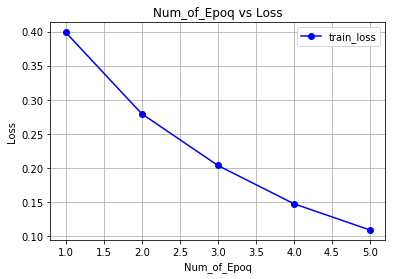

In [27]:
scr_nnc.graph_cost_func()

In [28]:
scr_nnc.loss_list

array([0.3988991 , 0.27953821, 0.2038564 , 0.14765162, 0.10924128])